In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [7]:
aliases = pd.read_csv("hillary-clinton-emails/Aliases.csv", index_col=0)

In [8]:
emailReceivers = pd.read_csv("hillary-clinton-emails/EmailReceivers.csv", index_col=0)

In [9]:
persons = pd.read_csv("hillary-clinton-emails/Persons.csv", index_col=0)

In [10]:
emails = pd.read_csv("hillary-clinton-emails/Emails.csv", index_col=0)

In [11]:
emails.head(1)

,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
Id,,,,,,,,,,,,,,,,,,,,,
1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,HRC_Email_296,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...


In [12]:
from wordcloud import WordCloud

In [14]:
email_full_texts = emails['ExtractedBodyText'].str.cat()

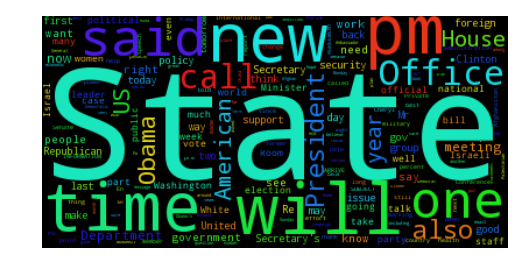

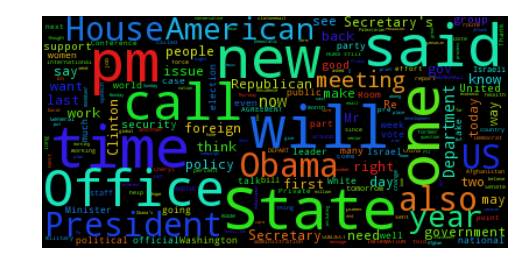

In [18]:
# Generate a word cloud image
wordcloud = WordCloud().generate(email_full_texts)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=50).generate(email_full_texts)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

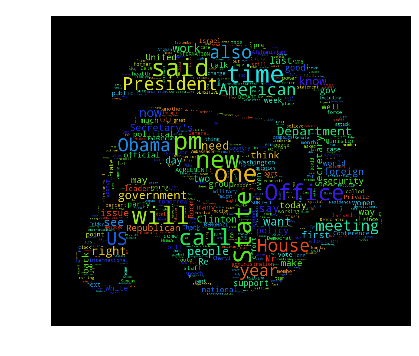

In [27]:
from os import path
from PIL import Image

stormtrooper_mask = np.array(Image.open(path.join(".", "stormtrooper_mask.png")))

#stopwords = set(STOPWORDS)
#stopwords.add("said")

wc = WordCloud(background_color="black", max_words=500, mask=stormtrooper_mask, max_font_size=80)
# generate word cloud
wc.generate(email_full_texts)

# store to file
wc.to_file(path.join(".", "stormtrooper_hillary_emails.png"))

# show
plt.imshow(wc)
plt.axis("off")
plt.figure()
#plt.imshow(stormtrooper_mask, cmap=plt.cm.gray)
#plt.axis("off")
plt.show()